# Citi Bike EDA

## Imports, Settings and Data Loading

In [1]:
from __future__ import annotations

# Standard library
import math
from typing import Any, Dict, Optional, Tuple
from pathlib import Path

# Scientific computing
import numpy as np
import pandas as pd
import itertools
from scipy.signal import periodogram
import statsmodels
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

# Visualization
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from matplotlib.offsetbox import AnchoredText
import seaborn as sns

# Machine learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor

In [2]:
pd.set_option("display.max_rows", 20)      
pd.set_option("display.width", 200)
pd.set_option("display.max_colwidth", 80)

In [3]:
OUT_DIR  = Path(r"..\data\processed")

#cleaned citi bike trip data
df_citibike = pd.read_pickle(OUT_DIR / "citibike_clean.pkl")

#citibike trip data rows with at least one missing value
df_citibike_missing = pd.read_pickle(OUT_DIR / "citibike_missing.pkl")

## Analyze Data With Missing Values

- From the cleaning part it is known that the data only has NaNs in the end/start lat/lng/name/id field

In [4]:
df_citibike_all = pd.concat([df_citibike,df_citibike_missing])

In [5]:
df_citibike_all.shape

(1388317, 14)

In [6]:
# Define column groups
START_COLS = ["start_lat", "start_lng", "start_station_id", "start_station_name"]
END_COLS = ["end_lat", "end_lng", "end_station_id", "end_station_name"]
ALL_COLS = START_COLS + END_COLS

GEO_LABELS = {
    "start_coord_missing": "Start coord missing",
    "start_station_id_missing": "Start station_id missing",
    "start_station_name_missing": "Start station_name missing",
    "end_coord_missing": "End coord missing",
    "end_station_id_missing": "End station_id missing",
    "end_station_name_missing": "End station_name missing",
}

df_citibike (clean):        1,383,739
df_citibike_missing:        4,578
total (clean + missing):    1,388,317


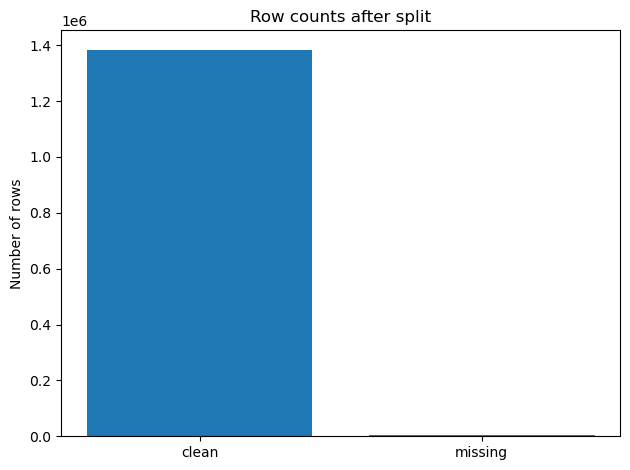

In [7]:
# missing vs clean
n_clean = len(df_citibike)
n_missing = len(df_citibike_missing)
n_total = n_clean + n_missing

print(f"df_citibike (clean):        {n_clean:,}")
print(f"df_citibike_missing:        {n_missing:,}")
print(f"total (clean + missing):    {n_total:,}")

plt.figure()
plt.bar(["clean", "missing"], [n_clean, n_missing])
plt.title("Row counts after split")
plt.ylabel("Number of rows")
plt.tight_layout()
plt.show()

In [8]:
def geo_issue_masks(df: pd.DataFrame) -> dict[str, pd.Series]:
    """Boolean masks for geo issues (no flag columns added)."""
    masks: dict[str, pd.Series] = {}

    for side in ("start", "end"):
        lat = f"{side}_lat"
        lng = f"{side}_lng"
        sid = f"{side}_station_id"
        sname = f"{side}_station_name"

        masks[f"{side}_coord_missing"] = df[lat].isna() | df[lng].isna()
        masks[f"{side}_station_id_missing"] = df[sid].isna()
        masks[f"{side}_station_name_missing"] = df[sname].isna()

    return masks


def summarize_masks(df: pd.DataFrame, masks: dict[str, pd.Series], labels: dict[str, str]) -> pd.DataFrame:
    """Count + percent summary for selected masks."""
    total = len(df)
    rows = []
    for key, label in labels.items():
        m = masks[key]
        cnt = int(m.sum())
        pct = 100.0 * cnt / total if total else 0.0
        rows.append({"issue": label, "count": cnt, "pct": pct})
    return pd.DataFrame(rows).sort_values("count", ascending=False, ignore_index=True)

In [9]:
#check how often each value is missing

masks = geo_issue_masks(df_citibike_all)
summary = summarize_masks(df_citibike_all, masks, GEO_LABELS)

print("GEOGRAPHIC ANOMALIES")
print("=" * 60)
for _, r in summary.iterrows():
    print(f"{r['issue']:.<40} {r['count']:>8,} ({r['pct']:>6.2f}%)")
print("=" * 60)

display(summary)


GEOGRAPHIC ANOMALIES
End coord missing.......................    4,075 (  0.29%)
End station_id missing..................    4,075 (  0.29%)
End station_name missing................    3,813 (  0.27%)
Start coord missing.....................      650 (  0.05%)
Start station_id missing................      650 (  0.05%)
Start station_name missing..............      650 (  0.05%)


,issue,count,pct
0,End coord missing,4075,0.293521
1,End station_id missing,4075,0.293521
2,End station_name missing,3813,0.274649
3,Start coord missing,650,0.046819
4,Start station_id missing,650,0.046819
5,Start station_name missing,650,0.046819


In [10]:
def missingness_patterns(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    """Count missingness patterns for the given columns."""
    miss = df[cols].isna()
    tab = miss.value_counts(sort=False).rename("count").reset_index()
    tab["pct"] = 100.0 * tab["count"] / len(df)
    return tab

# Reuse col groups, loop through them once to compute patterns
col_groups = [("start", START_COLS), ("end", END_COLS), ("all", ALL_COLS)]

# check missingness patterns
patterns = {}

for name, cols in col_groups:
    patterns[name] = missingness_patterns(df_citibike_all, cols)
    display(patterns[name].sort_values("count", ascending=False))

,start_lat,start_lng,start_station_id,start_station_name,count,pct
0,False,False,False,False,1387667,99.953181
1,True,True,True,True,650,0.046819


,end_lat,end_lng,end_station_id,end_station_name,count,pct
0,False,False,False,False,1384242,99.706479
2,True,True,True,True,3813,0.274649
1,True,True,True,False,262,0.018872


,start_lat,start_lng,start_station_id,start_station_name,end_lat,end_lng,end_station_id,end_station_name,count,pct
0,False,False,False,False,False,False,False,False,1383739,99.670248
2,False,False,False,False,True,True,True,True,3668,0.264205
3,True,True,True,True,False,False,False,False,503,0.036231
1,False,False,False,False,True,True,True,False,260,0.018728
5,True,True,True,True,True,True,True,True,145,0.010444
4,True,True,True,True,True,True,True,False,2,0.000144


start station:
- either all location features exist or none

end station:
- either all location features exist or none
- or it is everything missing expect the id

relationship:
- there is way more data with missing endstation information (4075) than with missing startstation information (650)

In [11]:
N = 10

mask_end_coords_missing_name_present = (
    df_citibike_all["end_lat"].isna()
    & df_citibike_all["end_lng"].isna()
    & df_citibike_all["end_station_id"].isna()
    & df_citibike_all["end_station_name"].notna()
)

subset = df_citibike_all.loc[mask_end_coords_missing_name_present].copy()

print(
    "Rows where end_lat/end_lng/end_station_id are missing but end_station_name is present:",
    f"{len(subset):,}",
)

display(subset.head(5))

subset_counts = subset["end_station_name"].value_counts().rename("subset_count").reset_index()
subset_counts = subset_counts.rename(columns={"index": "end_station_name"})

full_counts = df_citibike_all["end_station_name"].value_counts().rename("full_count").reset_index()
full_counts = full_counts.rename(columns={"index": "end_station_name"})

station_summary = subset_counts.merge(full_counts, on="end_station_name", how="left")
station_summary["pct_of_station_trips"] = 100.0 * station_summary["subset_count"] / station_summary["full_count"]
station_summary = station_summary.sort_values("pct_of_station_trips", ascending=False)

print("\nEnd station names — sorted by % of trips missing end coords:")
display(station_summary.head(N))


Rows where end_lat/end_lng/end_station_id are missing but end_station_name is present: 262


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,source_file
7013,5580EC8420A5F6A9,electric_bike,2024-11-11 08:38:09.546,2024-11-11 08:51:29.109,Schermerhorn St & Hoyt St,4479.10,Grand St & Elizabeth St,<NA>,40.688625,-73.985191,NaN,NaN,member,202411-citibike-tripdata_1.csv
9644,7A0DE811FCCF7B7F,electric_bike,2024-11-12 07:10:40.300,2024-11-12 07:30:04.790,56 St & Arnold Ave,5289.05,35 Ave & 37 St,<NA>,40.714840,-73.908997,NaN,NaN,casual,202411-citibike-tripdata_1.csv
13862,789FC5C1EC222F63,electric_bike,2024-11-13 09:37:05.810,2024-11-13 09:40:42.380,Bainbridge Ave & E 196 St,8615.01,Strong St & University Ave,<NA>,40.866482,-73.890419,NaN,NaN,casual,202411-citibike-tripdata_1.csv
39974,E71E679AF3B6C29C,electric_bike,2024-11-13 08:42:51.487,2024-11-13 08:50:18.510,India St & Manhattan Ave,5826.02,S 2 St & Kent Ave,<NA>,40.732323,-73.955086,NaN,NaN,member,202411-citibike-tripdata_2.csv
56066,6125304B5E67FA0D,electric_bike,2024-11-03 08:50:15.079,2024-11-03 09:03:24.056,Central Park West & W 85 St,7354.01,E 51 St & Lexington Ave,<NA>,40.784760,-73.969864,NaN,NaN,member,202411-citibike-tripdata_2.csv



End station names — sorted by % of trips missing end coords:


,end_station_name,subset_count,full_count,pct_of_station_trips
36,Jerome Ave & W 177 St,2,35,5.714286
74,47 Ave & 109 St,1,43,2.325581
38,St Nicholas Ave & W 157 St,2,108,1.851852
135,Strong St & University Ave,1,69,1.449275
22,W 170 St & University Ave,2,149,1.342282
3,Coffey St & Ferris St,4,310,1.290323
0,Broadway & W 37 St,7,553,1.265823
23,Grand Concourse & E 156 St,2,171,1.169591
5,Greene Ave & Myrtle Ave,4,367,1.089918
91,W Fordham Rd & Loring Pl N,1,98,1.020408


- not a station specific problem

In [12]:
# Investigate rows where ALL 8 geographic columns are missing
mask_all_geo_missing = (
    df_citibike_all["start_lat"].isna()
    & df_citibike_all["start_lng"].isna()
    & df_citibike_all["start_station_id"].isna()
    & df_citibike_all["start_station_name"].isna()
    & df_citibike_all["end_lat"].isna()
    & df_citibike_all["end_lng"].isna()
    & df_citibike_all["end_station_id"].isna()
    & df_citibike_all["end_station_name"].isna()
)

subset_all_missing = df_citibike_all.loc[mask_all_geo_missing].copy()

display(subset_all_missing.head(10))

# Check rideable type distribution
print("\nRideable type distribution:")
display(subset_all_missing["rideable_type"].value_counts())

# Check member vs casual
print("\nMember vs Casual:")
display(subset_all_missing["member_casual"].value_counts())


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,source_file
67,4BFF6E77979A15C2,electric_bike,2024-11-12 18:16:17.112,2024-11-12 18:20:20.579,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,member,202411-citibike-tripdata_1.csv
964,598E5825B236885C,electric_bike,2024-11-14 11:09:28.605,2024-11-14 12:10:52.756,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,member,202411-citibike-tripdata_1.csv
4749,2DF9B6178401C985,electric_bike,2024-11-09 22:43:09.260,2024-11-09 23:43:19.962,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,member,202411-citibike-tripdata_1.csv
5048,21B6FA44899664EE,electric_bike,2024-11-05 17:50:06.131,2024-11-05 17:53:40.088,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,member,202411-citibike-tripdata_1.csv
5239,81C1FE6C80ABCF10,electric_bike,2024-11-06 17:39:03.491,2024-11-06 17:45:18.284,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,casual,202411-citibike-tripdata_1.csv
5478,983CEDE43577DE2C,electric_bike,2024-11-07 16:14:52.980,2024-11-07 16:21:50.710,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,member,202411-citibike-tripdata_1.csv
9062,1320D879EE2E345A,electric_bike,2024-11-01 18:27:01.335,2024-11-01 18:49:59.771,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,member,202411-citibike-tripdata_1.csv
9581,354C41031F2B9BC3,electric_bike,2024-11-10 01:31:33.180,2024-11-10 01:45:20.474,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,member,202411-citibike-tripdata_1.csv
9834,C50E60292ED49635,electric_bike,2024-11-14 15:36:18.734,2024-11-14 15:44:29.959,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,member,202411-citibike-tripdata_1.csv
11032,7AEE9BB12559CCAD,electric_bike,2024-11-04 10:09:21.685,2024-11-04 10:14:43.461,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,member,202411-citibike-tripdata_1.csv



Rideable type distribution:


rideable_type
electric_bike    145
classic_bike       0
Name: count, dtype: int64


Member vs Casual:


member_casual
member    103
casual     42
Name: count, dtype: int64

- Suspicion: Is missingness highly correlated with electric bike trips?

In [13]:
# Add electric bike percentages to patterns

def add_pct_electric_bike(patterns: pd.DataFrame, df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    """Add pct_electric_bike for each missingness pattern."""
    miss = df[cols].isna()
    is_electric = (df["rideable_type"] == "electric_bike")

    pct = (
        miss.assign(_is_electric=is_electric)
        .groupby(cols)["_is_electric"]
        .mean()
        .mul(100)
        .rename("pct_electric_bike")
        .reset_index()
    )
    return patterns.merge(pct, on=cols, how="left")

patterns_with_ebike = {}

for name, cols in col_groups:
    patterns_with_ebike[name] = add_pct_electric_bike(patterns[name], df_citibike_all, cols)
    display(patterns_with_ebike[name].sort_values("count", ascending=False))

,start_lat,start_lng,start_station_id,start_station_name,count,pct,pct_electric_bike
0,False,False,False,False,1387667,99.953181,70.041227
1,True,True,True,True,650,0.046819,100.000000


,end_lat,end_lng,end_station_id,end_station_name,count,pct,pct_electric_bike
0,False,False,False,False,1384242,99.706479,69.986101
2,True,True,True,True,3813,0.274649,93.102544
1,True,True,True,False,262,0.018872,100.000000


,start_lat,start_lng,start_station_id,start_station_name,end_lat,end_lng,end_station_id,end_station_name,count,pct,pct_electric_bike
0,False,False,False,False,False,False,False,False,1383739,99.670248,69.97519
2,False,False,False,False,True,True,True,True,3668,0.264205,92.82988
3,True,True,True,True,False,False,False,False,503,0.036231,100.00000
1,False,False,False,False,True,True,True,False,260,0.018728,100.00000
5,True,True,True,True,True,True,True,True,145,0.010444,100.00000
4,True,True,True,True,True,True,True,False,2,0.000144,100.00000


- Baseline: **~70% electric bikes** in complete rows.  
- Missing **start** fields (all 4 missing): **650 trips → 100% electric bikes**.  
- Missing **end** fields (all 4 missing): **3,813 trips → 93.1% electric bikes**.  
- Missing **end coords + end_id** (name present): **262 trips → 100% electric bikes**.  
- **Conclusion:** missing geo/station info is **heavily concentrated in electric-bike trips**, this is something citibike should look into

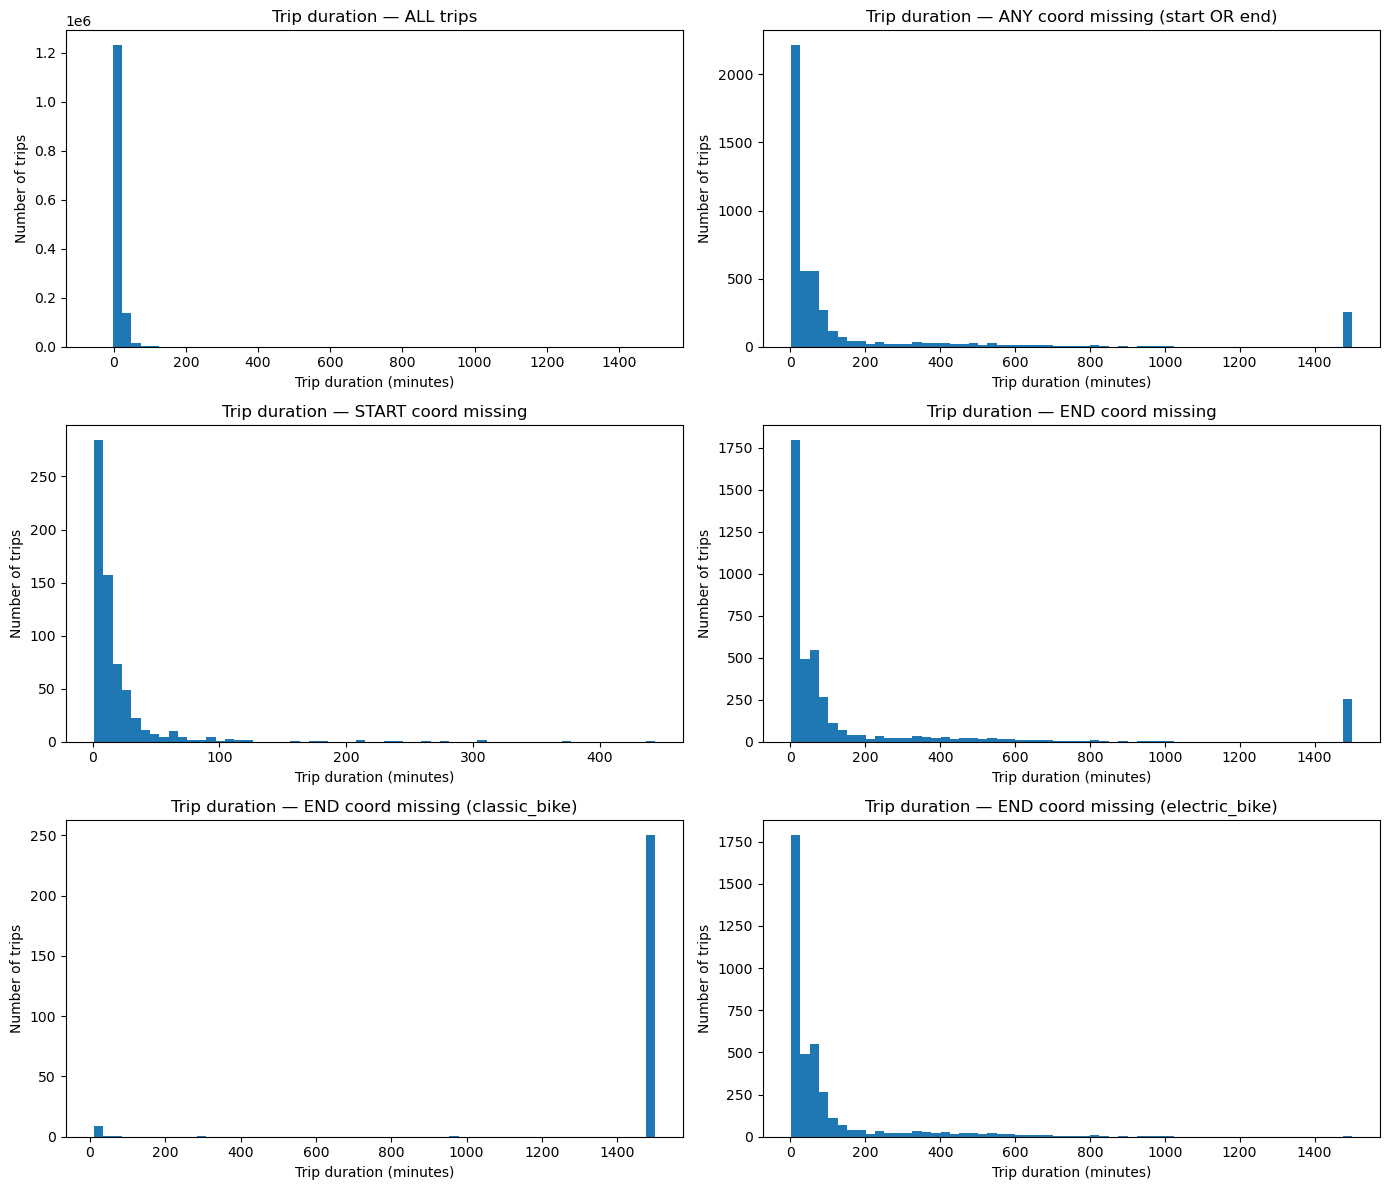

In [14]:
# Compute trip duration once
trip_minutes = (df_citibike_all["ended_at"] - df_citibike_all["started_at"]).dt.total_seconds() / 60.0

# Reuse masks already computed
mask_any_coord_missing = masks["start_coord_missing"] | masks["end_coord_missing"]
mask_start_coord_missing = masks["start_coord_missing"]
mask_end_coord_missing = masks["end_coord_missing"]

# Convenience mask for "all rows"
mask_all = pd.Series(True, index=df_citibike_all.index)


def plot_duration_hist_auto_x(
    ax: plt.Axes,
    minutes: pd.Series,
    mask: pd.Series,
    title: str,
    *,
    bins: int = 60,
) -> None:
    """Plot histogram of trip durations for a subset into a given axis."""
    x = minutes.loc[mask].astype(float)
    if x.empty:
        ax.set_visible(False)
        return

    ax.hist(x, bins=bins)
    ax.set_title(title)
    ax.set_xlabel("Trip duration (minutes)")
    ax.set_ylabel("Number of trips")



# CLEANED: Single loop instead of 7 individual calls
plots_config = [
    ("ALL trips", mask_all),
    ("ANY coord missing (start OR end)", mask_any_coord_missing),
    ("START coord missing", mask_start_coord_missing),
    ("END coord missing", mask_end_coord_missing),
    (
        "END coord missing (classic_bike)",
        mask_end_coord_missing & (df_citibike_all["rideable_type"] == "classic_bike"),
    ),
    (
        "END coord missing (electric_bike)",
        mask_end_coord_missing & (df_citibike_all["rideable_type"] == "electric_bike"),
    ),
]

fig, axes = plt.subplots(3, 2, figsize=(14, 12))
axes = axes.ravel()

for ax, (label, mask) in zip(axes, plots_config):
    plot_duration_hist_auto_x(ax, trip_minutes, mask, f"Trip duration — {label}")

plt.tight_layout()
plt.show()


There’s one clear difference between the overall trip-duration distribution and the missing-location subsets: a noticeable spike around **~ 1,500 minutes ( ~ 1 day)**. This spike is **not** present in the full dataset and is **entirely driven by the tiny subset of classic-bike trips** within the missing-data group (**~ n = 260**), making it a particularly interesting 

In [15]:
# closer look at trip duration of rows with missing date with classic bikes

trip_td = df_citibike_all["ended_at"] - df_citibike_all["started_at"]

mask_classic_end_missing = (
    masks["end_coord_missing"]
    & (df_citibike_all["rideable_type"] == "classic_bike")
)

x = trip_td.loc[mask_classic_end_missing]


def fmt_dd_hh_mm(td: pd.Timedelta) -> str:
    """Format timedelta as dd:hh:mm."""
    td = pd.Timedelta(td)
    total_minutes = int(td.total_seconds() // 60)
    days = total_minutes // (24 * 60)
    hours = (total_minutes % (24 * 60)) // 60
    minutes = total_minutes % 60
    return f"{days:02d}:{hours:02d}:{minutes:02d}"


# Counts
n = int(x.shape[0])
n_over_24h = int((x > pd.Timedelta(hours=24)).sum())

# Quartiles/min/max
stats = {
    "min": x.min(),
    "q25": x.quantile(0.25),
    "median": x.quantile(0.50),
    "q75": x.quantile(0.75),
    "max": x.max(),
}

duration_summary = pd.DataFrame(
    {
        "n": [n],
        "n_over_24h": [n_over_24h],
        "min_dd_hh_mm": [fmt_dd_hh_mm(stats["min"]) if n else None],
        "q25_dd_hh_mm": [fmt_dd_hh_mm(stats["q25"]) if n else None],
        "median_dd_hh_mm": [fmt_dd_hh_mm(stats["median"]) if n else None],
        "q75_dd_hh_mm": [fmt_dd_hh_mm(stats["q75"]) if n else None],
        "max_dd_hh_mm": [fmt_dd_hh_mm(stats["max"]) if n else None],
    }
)

display(duration_summary)


,n,n_over_24h,min_dd_hh_mm,q25_dd_hh_mm,median_dd_hh_mm,q75_dd_hh_mm,max_dd_hh_mm
0,263,250,00:00:10,01:00:59,01:00:59,01:00:59,01:00:59


It is likely that this data is from rides that could not be properly ended and city bike has a system which automatically ends rides after 25 hours.

Maybe:
- **the bike was in a severe accident**, so the rider was not able to return it
- it was not properly locked
- ...

Outlook: Further analysis could check whether these trips more often started from high-risk stations, went through high-risk areas, etc. If there is a strong correlation, this subset could include a lot of accidents, which could be valuable information.


In [16]:
del df_citibike_all, df_citibike_missing

## Membership & Rideable Type

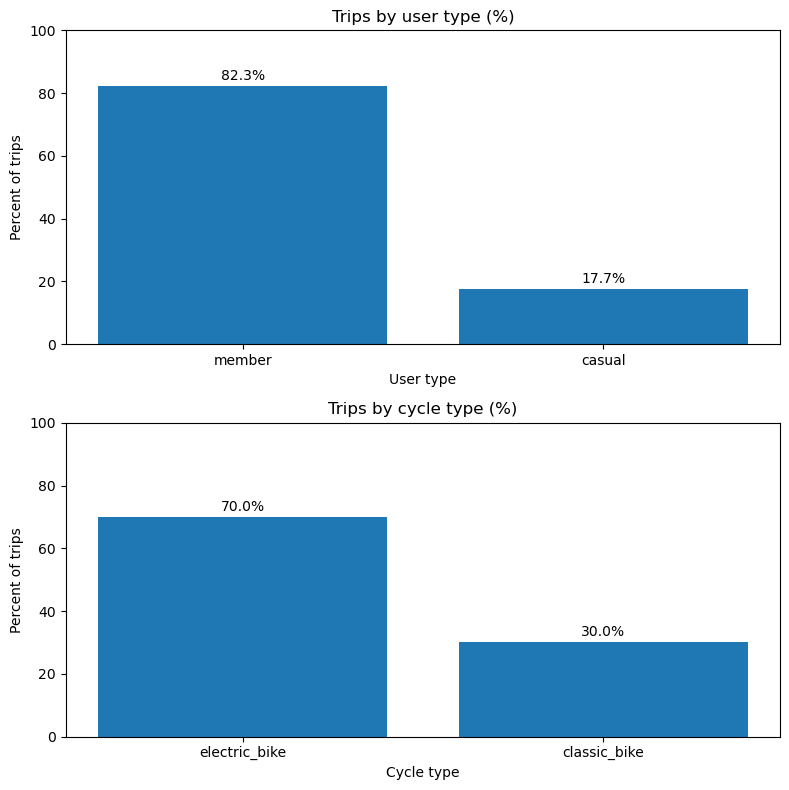

In [17]:
def _percent_series_no_na(s: pd.Series) -> pd.Series:
    """Percentages (0-100) for a Series (assumes no NaNs)."""
    return s.value_counts(normalize=True).mul(100).sort_values(ascending=False)

def plot_trip_percentages(df: pd.DataFrame) -> None:
    required = ["member_casual", "rideable_type"]
    missing_cols = [c for c in required if c not in df.columns]
    if missing_cols:
        raise KeyError(f"df_citibike is missing required columns: {missing_cols}")

    user_pct = _percent_series_no_na(df["member_casual"])
    cycle_pct = _percent_series_no_na(df["rideable_type"])

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

    # 1) Trips by user type (%)
    axes[0].bar(user_pct.index.astype(str), user_pct.values)
    axes[0].set_title("Trips by user type (%)")
    axes[0].set_ylabel("Percent of trips")
    axes[0].set_xlabel("User type")
    axes[0].set_ylim(0, 100)
    for i, v in enumerate(user_pct.values):
        axes[0].text(i, v + 1, f"{v:.1f}%", ha="center", va="bottom")

    # 2) Trips by cycle type (%)
    axes[1].bar(cycle_pct.index.astype(str), cycle_pct.values)
    axes[1].set_title("Trips by cycle type (%)")
    axes[1].set_ylabel("Percent of trips")
    axes[1].set_xlabel("Cycle type")
    axes[1].set_ylim(0, 100)
    for i, v in enumerate(cycle_pct.values):
        axes[1].text(i, v + 1, f"{v:.1f}%", ha="center", va="bottom")

    plt.tight_layout()
    plt.show()

plot_trip_percentages(df_citibike)

## Trip Duration/Distance

In [18]:
#plot trip distance and duration distribution
def _haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0088
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lat2*0 + lon2 - lon1  # keep shape
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

def distance_km_series(df: pd.DataFrame) -> pd.Series:
    cols = ["start_lat","start_lng","end_lat","end_lng"]
    d = df[cols].dropna().copy()
    km = _haversine_km(
        d["start_lat"].to_numpy(), d["start_lng"].to_numpy(),
        d["end_lat"].to_numpy(),   d["end_lng"].to_numpy()
    )
    km = km[np.isfinite(km)]
    km = km[km >= 0]
    return pd.Series(km, name="distance_km")

def duration_min_series(df: pd.DataFrame) -> pd.Series:
    d = df[["started_at","ended_at"]].dropna().copy()
    d["started_at"] = pd.to_datetime(d["started_at"], errors="coerce")
    d["ended_at"]   = pd.to_datetime(d["ended_at"], errors="coerce")
    d = d.dropna()
    minutes = (d["ended_at"] - d["started_at"]).dt.total_seconds() / 60.0
    minutes = minutes.to_numpy()
    minutes = minutes[np.isfinite(minutes)]
    minutes = minutes[minutes >= 0]
    return pd.Series(minutes, name="duration_min")

def summarize_series(x: pd.Series) -> pd.DataFrame:
    x = x.dropna()
    out = pd.DataFrame(
        {
            "count": [int(x.shape[0])],
            "mean":  [float(x.mean())],
            "std":   [float(x.std(ddof=1))],
            "min":   [float(x.min())],
            "max":   [float(x.max())],
        }
    )
    return out

def plot_trip_distance_hist(df: pd.DataFrame, bins: int = 60, max_km: float = 20.0) -> pd.DataFrame:
    """Histogram + summary stats (mean/std/min/max). Returns stats table."""
    km = distance_km_series(df)
    stats = summarize_series(km)

    km_plot = km[km <= max_km]
    plt.figure(figsize=(10,4))
    plt.hist(km_plot, bins=bins)
    plt.title("Trip distance distribution")
    plt.xlabel("Distance (km)")
    plt.ylabel("Number of trips")
    plt.tight_layout()
    plt.show()

    display(stats)
    return stats

def plot_trip_duration_hist(df: pd.DataFrame, bins: int = 60, max_min: float = 120.0) -> pd.DataFrame:
    """Histogram + summary stats (mean/std/min/max). Returns stats table."""
    minutes = duration_min_series(df)
    stats = summarize_series(minutes)

    minutes_plot = minutes[minutes <= max_min]
    plt.figure(figsize=(10,4))
    plt.hist(minutes_plot, bins=bins)
    plt.title("Trip duration distribution")
    plt.xlabel("Duration (minutes)")
    plt.ylabel("Number of trips")
    plt.tight_layout()
    plt.show()

    display(stats)
    return stats

# one chart per cell:
# plot_trip_distance_hist(df_citibike)
# plot_trip_duration_hist(df_citibike)

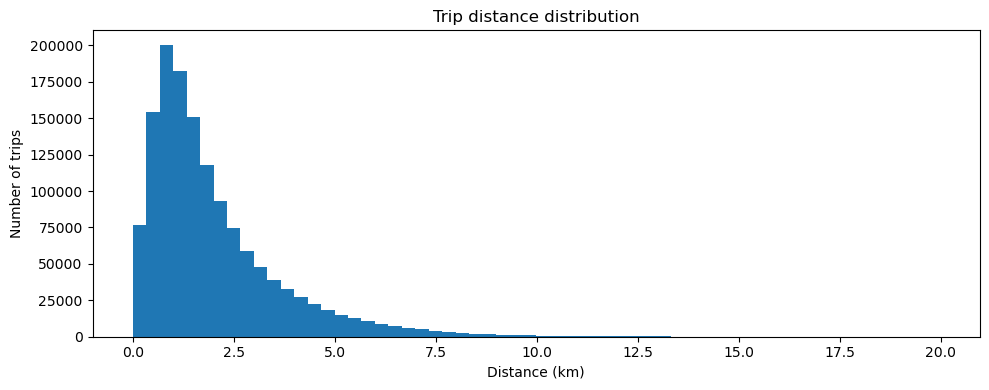

,count,mean,std,min,max
0,1383739,2.004589,1.712904,0.0,25.426903


In [19]:
plot_trip_distance_hist(df_citibike);

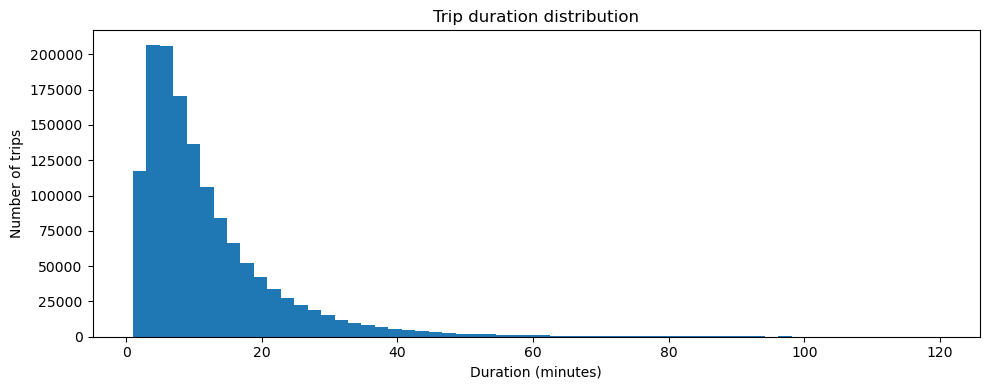

,count,mean,std,min,max
0,1383730,12.364228,17.840014,1.000933,1489.001833


In [20]:
plot_trip_duration_hist(df_citibike);

trip length and duration seem highly correlated which was expected

## Usage per Monthly/Weekday/Hour

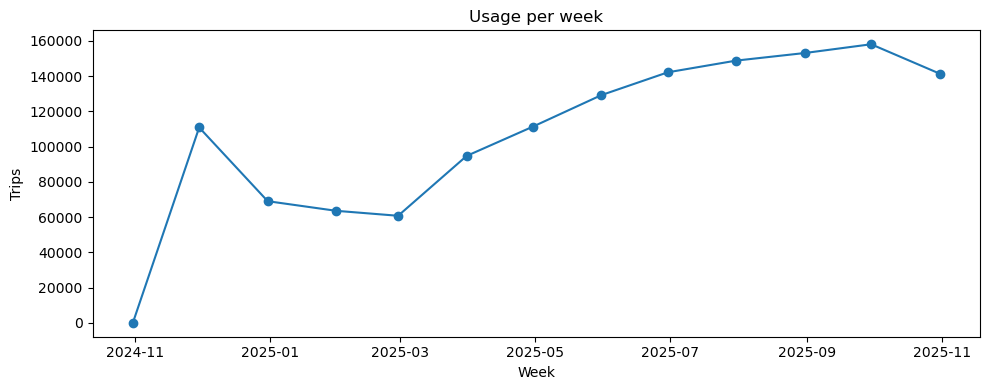

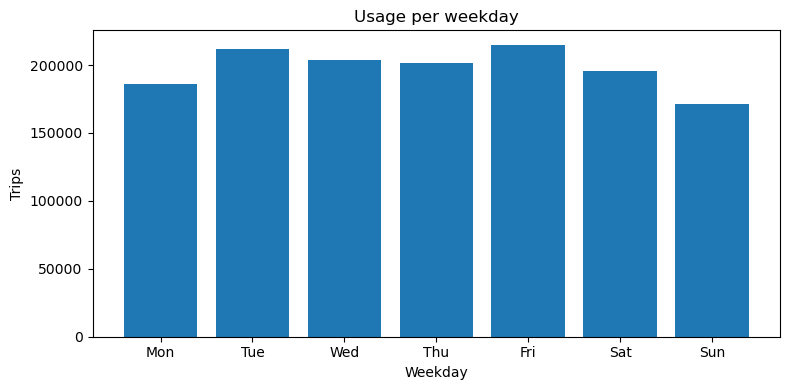

In [21]:
def plot_usage_time_profiles(df: pd.DataFrame, time_col: str = "started_at") -> None:
    if time_col not in df.columns:
        raise KeyError(f"Missing required column: '{time_col}'")

    d = df.copy()

    # --- 1) Usage per week (line + dots) ---
    monthly = d.set_index(time_col).resample("ME").size()

    plt.figure(figsize=(10, 4))
    plt.plot(monthly.index, monthly.values, marker="o")  # <- dots
    plt.title("Usage per week")
    plt.xlabel("Week")
    plt.ylabel("Trips")
    plt.tight_layout()
    plt.show()

    # --- 2) Usage per weekday (bar) ---
    weekday_order = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
    weekday_counts = d[time_col].dt.dayofweek.value_counts().sort_index()
    weekday_counts.index = [weekday_order[i] for i in weekday_counts.index]

    plt.figure(figsize=(8, 4))
    plt.bar(weekday_counts.index, weekday_counts.values)
    plt.title("Usage per weekday")
    plt.xlabel("Weekday")
    plt.ylabel("Trips")
    plt.tight_layout()
    plt.show()

plot_usage_time_profiles(df_citibike, time_col="started_at")

monthly:
- seasonality is less clear than i expected, maybe because of a generell increasing trend in city bike rides
- unexpect peak in the winter during december (christmas/winter break tourism traffic?)

Weekday:
- I would have expect the weekdays to be more dominant because of rush hours, but leisure time traffic on the weekends seems to almost even it out

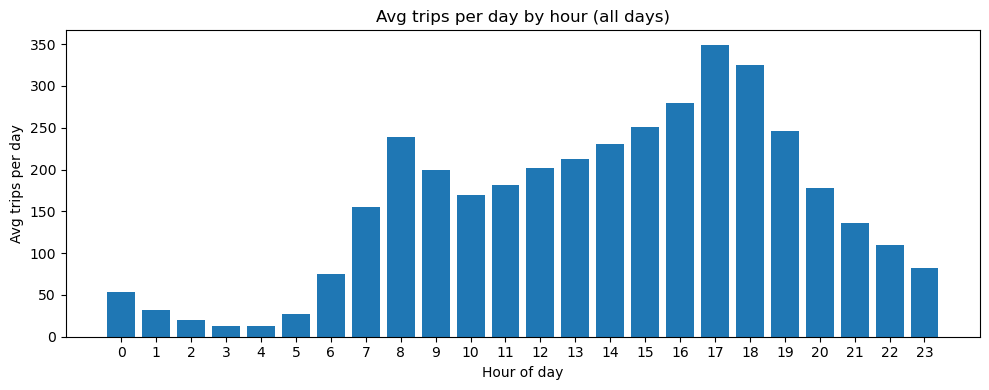

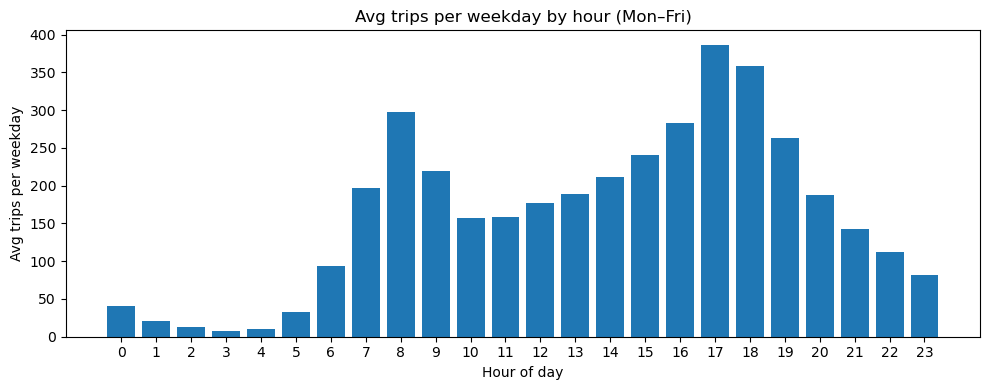

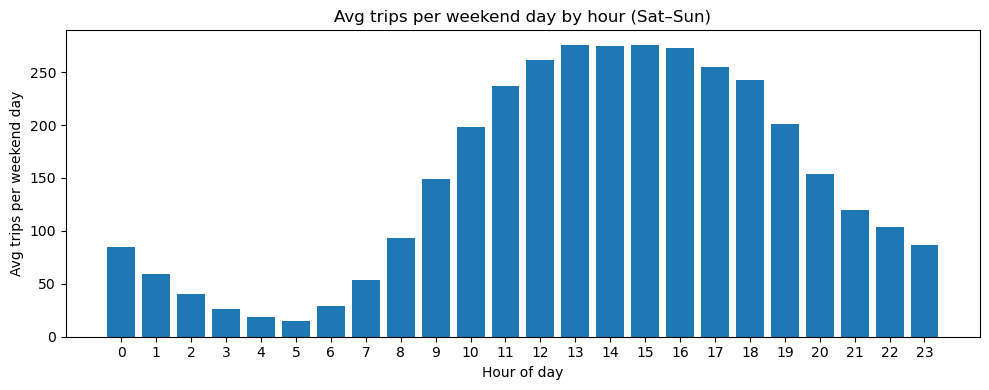

In [22]:
def plot_usage_by_hour_week_split_norm_per_day(
    df: pd.DataFrame,
    ts_col: str = "started_at",
) -> None:
    """
    3 bar charts (normalized per day):
      1) Avg trips per day by hour (all days)
      2) Avg trips per weekday by hour (Mon–Fri)
      3) Avg trips per weekend day by hour (Sat–Sun)
    """
    if ts_col not in df.columns:
        raise KeyError(f"DataFrame must contain column '{ts_col}'.")

    d = df[[ts_col]].copy()

    d["date"] = d[ts_col].dt.date
    d["hour"] = d[ts_col].dt.hour
    d["dow"] = d[ts_col].dt.dayofweek
    d["is_weekend"] = d["dow"] >= 5

    def avg_trips_per_day_by_hour(sub: pd.DataFrame) -> pd.Series:
        # count trips per (date, hour), then average across dates
        daily_hour_counts = (
            sub.groupby(["date", "hour"])
               .size()
               .unstack("hour", fill_value=0)
        )
        # ensure 0..23 always present
        daily_hour_counts = daily_hour_counts.reindex(columns=range(24), fill_value=0)
        return daily_hour_counts.mean(axis=0)

    hours_all = avg_trips_per_day_by_hour(d)
    hours_weekdays = avg_trips_per_day_by_hour(d.loc[~d["is_weekend"]])
    hours_weekends = avg_trips_per_day_by_hour(d.loc[d["is_weekend"]])

    # 1) All days
    plt.figure(figsize=(10, 4))
    plt.bar(hours_all.index, hours_all.values)
    plt.title("Avg trips per day by hour (all days)")
    plt.xlabel("Hour of day")
    plt.ylabel("Avg trips per day")
    plt.xticks(range(24))
    plt.tight_layout()
    plt.show()

    # 2) Weekdays
    plt.figure(figsize=(10, 4))
    plt.bar(hours_weekdays.index, hours_weekdays.values)
    plt.title("Avg trips per weekday by hour (Mon–Fri)")
    plt.xlabel("Hour of day")
    plt.ylabel("Avg trips per weekday")
    plt.xticks(range(24))
    plt.tight_layout()
    plt.show()

    # 3) Weekends
    plt.figure(figsize=(10, 4))
    plt.bar(hours_weekends.index, hours_weekends.values)
    plt.title("Avg trips per weekend day by hour (Sat–Sun)")
    plt.xlabel("Hour of day")
    plt.ylabel("Avg trips per weekend day")
    plt.xticks(range(24))
    plt.tight_layout()
    plt.show()

plot_usage_by_hour_week_split_norm_per_day(df_citibike, ts_col="started_at")

Weekday:
- rush hour dominates
  
Weekend:
- night and midday traffic are severly increased

## Stations

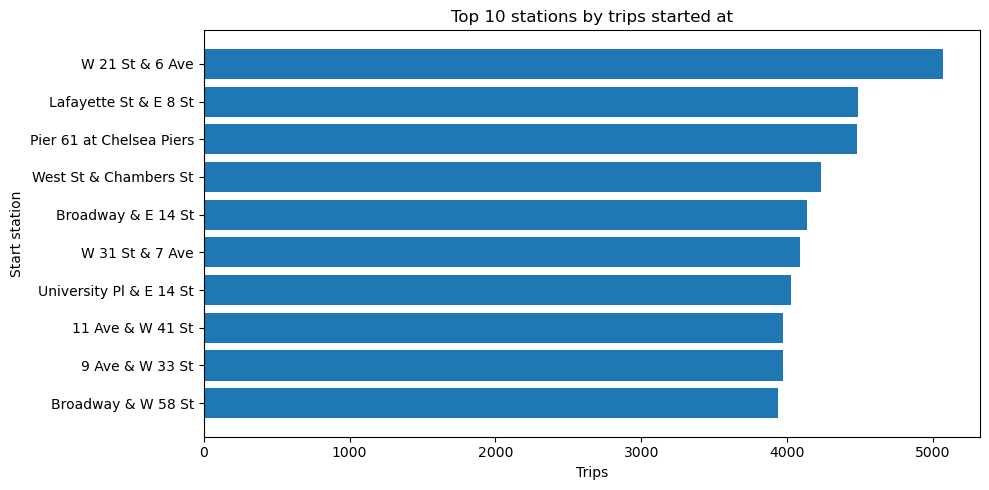

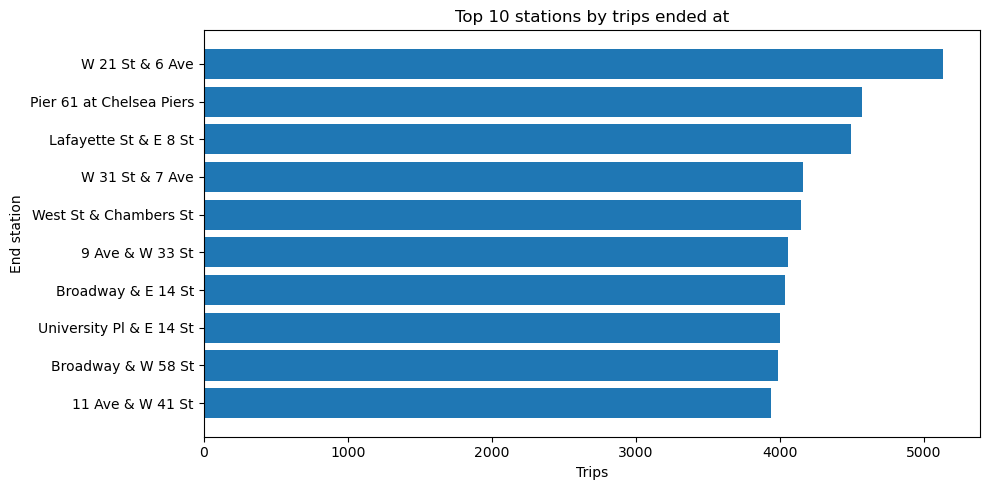

In [23]:
def plot_top10_start_end_stations(
    df: pd.DataFrame,
    start_name_col: str = "start_station_name",
    end_name_col: str = "end_station_name",
    top_n: int = 10,
) -> None:
    """
    Plots two separate bar charts:
      1) Top N stations by # trips started at (start_station_name)
      2) Top N stations by # trips ended at (end_station_name)
    Station name is used as the identifier.
    """
    # --- Top start stations ---
    top_start = (
        df[start_name_col]
        .astype(str)
        .value_counts()
        .head(top_n)
        .sort_values(ascending=True)  # for horizontal bar ordering
    )

    plt.figure(figsize=(10, 5))
    plt.barh(top_start.index, top_start.values)
    plt.title(f"Top {top_n} stations by trips started at")
    plt.xlabel("Trips")
    plt.ylabel("Start station")
    plt.tight_layout()
    plt.show()

    # --- Top end stations ---
    top_end = (
        df[end_name_col]
        .astype(str)
        .value_counts()
        .head(top_n)
        .sort_values(ascending=True)
    )

    plt.figure(figsize=(10, 5))
    plt.barh(top_end.index, top_end.values)
    plt.title(f"Top {top_n} stations by trips ended at")
    plt.xlabel("Trips")
    plt.ylabel("End station")
    plt.tight_layout()
    plt.show()


# example
plot_top10_start_end_stations(df_citibike)

total incoming and outgoing traffic seems to be really balanced for each station, the top 10 for both are really similar

In [24]:
# analyse how many percent of the traffic of each station goes to their top 1...n destination

def plot_avg_ranked_destination_shares(
    df: pd.DataFrame,
    start_col: str = "start_station_name",
    end_col: str = "end_station_name",
    k: int = 10,
    min_outgoing: int = 100,
) -> pd.Series:
    """
    For each origin station:
      - find its individual top-k destination stations
      - compute share to rank 1..k (as % of that origin's outgoing trips)
      - compute share to 'Other' = everything not in its top-k
    Keep only origins with total outgoing > min_outgoing.
    Then average these shares across origins (unweighted) and plot a bar chart.

    Returns the averaged shares (in %).
    """

    # OD counts
    od = (
        df.groupby([start_col, end_col])
        .size()
        .rename("n")
        .reset_index()
    )

    # Total outgoing per origin, filter by min_outgoing
    totals = od.groupby(start_col)["n"].sum().rename("total_out")
    valid_origins = totals[totals > min_outgoing].index
    od = od[od[start_col].isin(valid_origins)].copy()
    totals = totals.loc[valid_origins]

    if od.empty:
        raise ValueError(f"No origin stations with more than {min_outgoing} outgoing trips.")

    # Rank destinations within each origin by outgoing volume
    od = od.sort_values([start_col, "n"], ascending=[True, False])
    od["rank"] = od.groupby(start_col)["n"].rank(method="first", ascending=False)

    # Keep only top-k ranks
    topk = od[od["rank"] <= k].copy()
    topk["rank"] = topk["rank"].astype(int)

    # Wide table: one row per origin, columns = ranks 1..k with counts
    wide = (
        topk.pivot_table(index=start_col, columns="rank", values="n", aggfunc="sum", fill_value=0)
        .reindex(columns=range(1, k + 1), fill_value=0)
    )

    # Convert counts to shares
    wide = wide.div(totals, axis=0)  # shares for ranks 1..k
    wide["Other"] = (1.0 - wide.sum(axis=1)).clip(lower=0.0)

    # Average across origins (unweighted mean)
    avg_shares = wide.mean(axis=0) * 100  # percent

    # Plot
    labels = [f"Rank {i}" for i in range(1, k + 1)] + ["Other"]
    values = [avg_shares.get(i, 0.0) for i in range(1, k + 1)] + [avg_shares["Other"]]

    plt.figure(figsize=(10, 4))
    plt.bar(labels, values)
    plt.title(f"Avg outgoing traffic share by destination rank (origins with > {min_outgoing} trips)")
    plt.xlabel("Destination rank within origin's top list")
    plt.ylabel("Average share of outgoing trips (%)")
    plt.xticks(rotation=30, ha="right")
    plt.ylim(0, max(values) * 1.15 if max(values) > 0 else 1)
    plt.tight_layout()
    plt.show()

    return avg_shares

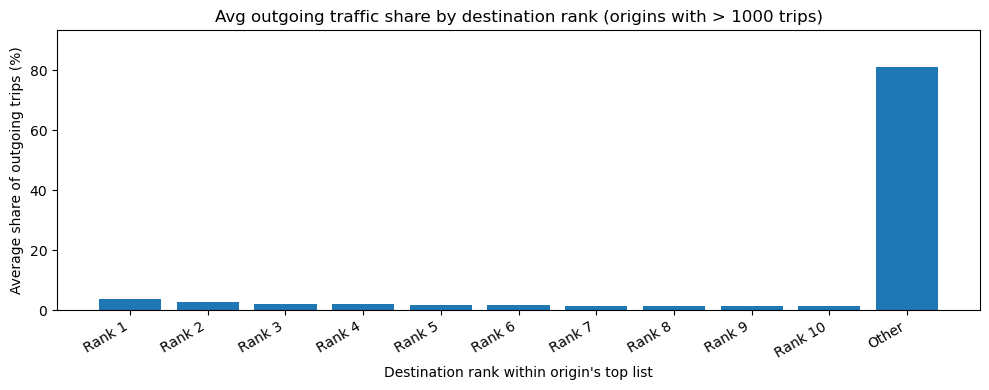

rank
1         3.535779
2         2.563692
3         2.141290
4         1.889389
5         1.715735
6         1.592526
7         1.482366
8         1.393229
9         1.319085
10        1.256844
Other    81.110066
dtype: float64

In [25]:
plot_avg_ranked_destination_shares(df_citibike, k=10, min_outgoing=1000)

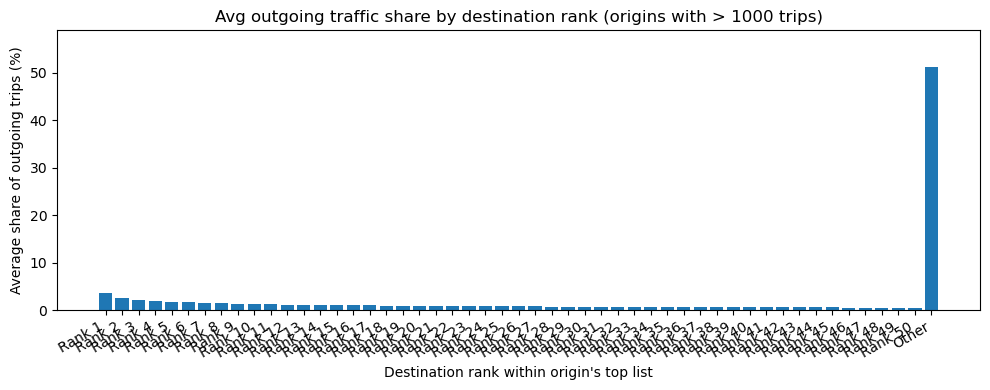

rank
1         3.535779
2         2.563692
3         2.141290
4         1.889389
5         1.715735
           ...    
47        0.520110
48        0.512826
49        0.504730
50        0.498567
Other    51.289151
Length: 51, dtype: float64

In [26]:
plot_avg_ranked_destination_shares(df_citibike, k=50, min_outgoing=1000)

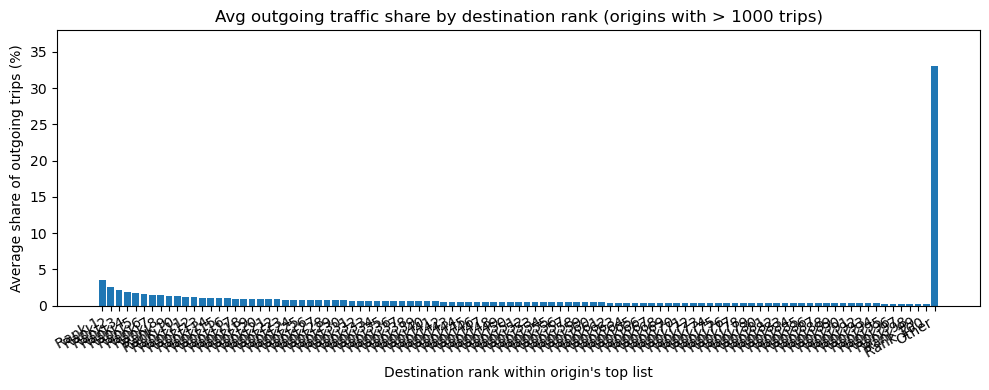

rank
1         3.535779
2         2.563692
3         2.141290
4         1.889389
5         1.715735
           ...    
97        0.283803
98        0.280922
99        0.278430
100       0.276502
Other    33.004608
Length: 101, dtype: float64

In [27]:
plot_avg_ranked_destination_shares(df_citibike, k=100, min_outgoing=1000)

- surprisingly even when looking at the top 100 destinations on average 33% of traffic goes to other stations
- this is even more suprising considering the average riding distance of 2 kilometers

-> there needs to be a very high station density to justify that